<h2>Analyzing Real Time Data Using New York City Bike Data</h2>

<p>Objective: Calculate the number of bikes available every minute for an hour across all of New York City. Activity is defined as the total number of bikes taken out or returned.</p>

<h3>Download the Data</h3>

In [1]:
import requests # Requests is a package that allows downloading of data from any online source
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as lite
import time
import collections
from pandas.io.json import json_normalize
from dateutil.parser import parse 

%matplotlib inline

In [2]:
r = requests.get("http://www.citibikenyc.com/stations/json")
r.json()

{u'executionTime': u'2015-10-04 10:49:36 PM',
 u'stationBeanList': [{u'altitude': u'',
   u'availableBikes': 21,
   u'availableDocks': 18,
   u'city': u'',
   u'id': 72,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-10-04 10:47:25 PM',
   u'latitude': 40.76727216,
   u'location': u'',
   u'longitude': -73.99392888,
   u'postalCode': u'',
   u'stAddress1': u'W 52 St & 11 Ave',
   u'stAddress2': u'',
   u'stationName': u'W 52 St & 11 Ave',
   u'statusKey': 1,
   u'statusValue': u'In Service',
   u'testStation': False,
   u'totalDocks': 39},
  {u'altitude': u'',
   u'availableBikes': 28,
   u'availableDocks': 4,
   u'city': u'',
   u'id': 79,
   u'landMark': u'',
   u'lastCommunicationTime': u'2015-10-04 10:49:00 PM',
   u'latitude': 40.71911552,
   u'location': u'',
   u'longitude': -74.00666661,
   u'postalCode': u'',
   u'stAddress1': u'Franklin St & W Broadway',
   u'stAddress2': u'',
   u'stationName': u'Franklin St & W Broadway',
   u'statusKey': 1,
   u'statusValue': u'I

In [3]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [4]:
# number of docks

len(r.json()['stationBeanList'])

508

In [5]:
# unique list of keys for each station listing

key_list = [] 
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)
print(key_list)

[u'availableDocks', u'totalDocks', u'city', u'altitude', u'stAddress2', u'longitude', u'lastCommunicationTime', u'postalCode', u'statusValue', u'testStation', u'stAddress1', u'stationName', u'landMark', u'latitude', u'statusKey', u'availableBikes', u'id', u'location']


In [6]:
df = json_normalize(r.json()['stationBeanList'])
print(df)

    altitude  availableBikes  availableDocks city    id landMark  \
0                         21              18         72            
1                         28               4         79            
2                         13              14         82            
3                         10              50         83            
4                         21              16        116            
5                         14               5        119            
6                          5              14        120            
7                         27               3        127            
8                          0              29        128            
9                         28              18        137            
10                        10              14        143            
11                         3              16        144            
12                        32               7        146            
13                        24               9    

<h3>Quick data exploration</h3>

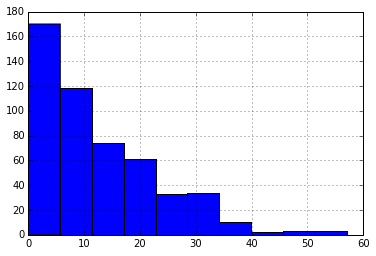

In [7]:
# available bikes

df['availableBikes'].hist()
plt.show()

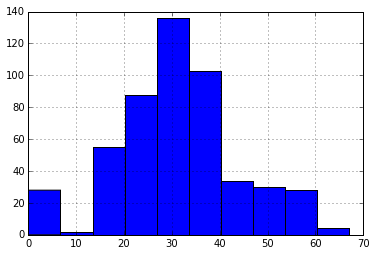

In [8]:
# total docks

df['totalDocks'].hist()
plt.show()

In [9]:
# mean of stations that are active 

condition = (df["statusValue"] == "In Service")
df[condition]["totalDocks"].mean()

32.778481012658226

In [10]:
# median of stations that are active; alternative syntax to above 

df[df["statusValue"] == "In Service"]["totalDocks"].median()

31.0

<h3>Store Data into SQLite DB</h3>

In [11]:
# db connection 

con = lite.connect("citi_bike.db")
cur = con.cursor()

In [12]:
# create table for citibike reference; insert data

insert_reference = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"

def create_reference():
    with con: 
        cur.execute("CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, landMark TEXT, latitude NUMERIC, location TEXT)")

        for station in r.json()["stationBeanList"]: 
            cur.execute(insert_reference, (station["id"],station["totalDocks"],station["city"],station["altitude"],station["stAddress2"],station["longitude"],station["postalCode"],station["testStation"],station["stAddress1"],station["stationName"],station["landMark"],station["latitude"],station["location"]))

create_reference() 

In [ ]:
# create table for available bikes; insert and update data 

station_ids = df["id"].tolist()
station_ids = ["_" + str(x) + " INT" for x in station_ids]
insert_bikes = "INSERT INTO available_bikes(execution_time) VALUES (?)"

def create_avail_bikes(): 
    with con: 
        cur.execute("CREATE TABLE available_bikes ( execution_time INT, " + ", ".join(station_ids) + ");")
        
        for i in range(60): 
            r = requests.get("http://www.citibikenyc.com/stations/json")
            exec_time = parse(r.json()["executionTime"])  

            cur.execute(insert_bikes, (exec_time.strftime("%s"),))
            con.commit()

        id_bikes = collections.defaultdict(int)
        update_bikes = "UPDATE available_bikes SET _" + str(k) + " = " + str(v) + " WHERE execution_time = " + exec_time.strftime('%s') + ";"
        for station in r.json()["stationBeanList"]: 
            id_bikes[station["id"]] = station["availableBikes"]

            # loop through id_bikes dictionary; k = station id, v = available bikes  
            for k, v in id_bikes.iteritems(): 

                # update available bikes _stationid =  available bikes where execution_time = exec_time 
                cur.execute(update_bikes)

        con.commit()

        # pause the program for 60 seconds  
        time.sleep(60)

create_avail_bikes()

<h3> Analyze the results</h3>

In [ ]:
def get_bikes(): 
    df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY execution_time",con,index_col='execution_time')
    df
    
get_bikes() 